In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from RateTraining import *

In [3]:
npar, tpar, trpar, cpar, rpar = create_default_params_rate()
tpar['stim_off'] = 50
npar['net_size'] = 500

In [4]:
def gen_rand_stim(n_par, time_par):
    N = n_par['net_size']
    dt = time_par['dt']
    timesteps = int(time_par['total_time']/dt)
    
    stim = np.zeros((N, timesteps))
    for row in range(N):
        rstim = 2 * sp.stats.uniform.rvs(0, 1) - 1 # random stim weight from -1, 1
        stim[row][int(time_par['stim_on']/dt):int(time_par['stim_off']/dt)] = rstim
    return stim

In [5]:
def gen_sine_targets(n_par, time_par): 
    N = n_par['net_size']
    dt = time_par['dt']
    timesteps = int(time_par['total_time']/dt)
    
    targets = np.zeros((N, timesteps))
    for i in range(N):
        A = sp.stats.uniform.rvs() + 0.5
        t0 = sp.stats.uniform.rvs() * 2000
        t1 = sp.stats.uniform.rvs() * 1500 + 500
        x = np.linspace(0, time_par['total_time'], timesteps)
        targets[i] = A * np.sin(2 * np.pi * (x - t0)/t1)
    return targets

In [6]:
def gen_saw_targs(n_par, time_par):
    N = n_par['net_size']
    dt = time_par['dt']
    timesteps = int(time_par['total_time']/dt)

    targets = np.zeros((N, timesteps))
    t = np.linspace(0, time_par['total_time'], timesteps)
    for i in range(N):
        A = sp.stats.uniform.rvs() + 0.5
        t0 = sp.stats.uniform.rvs() * 2 * np.pi
        t1 = sp.stats.uniform.rvs() * 1000 + 500
        targets[i] = A * sp.signal.sawtooth(2 * np.pi * (t - t0)/t1, 0.5)
    
    return targets

In [7]:
stargs = gen_saw_targs(npar, tpar)

In [8]:
stim = gen_rand_stim(npar, tpar)

In [9]:
targs = gen_sine_targets(npar, tpar)

In [10]:
np.shape(targs)

(500, 2000)

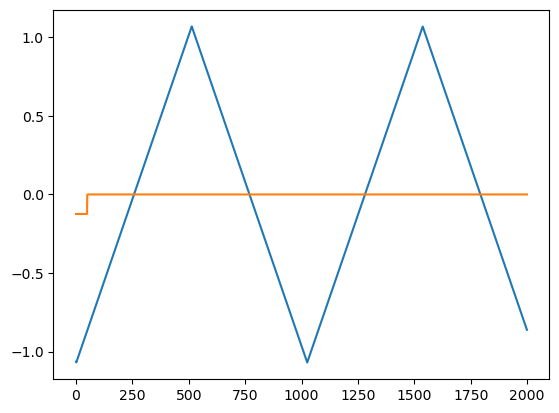

In [11]:
plt.plot(stargs[1])
plt.plot(stim[1])

In [12]:
net = RateTraining(npar, tpar, trpar, cpar, rpar)
net.nloop = 200

In [13]:
x, Hx, errs, rel_errs = net.train_rate(stim, stargs)

training trial 0
training trial 25
training trial 50
training trial 75
training trial 100
training trial 125
training trial 150
training trial 175


In [14]:
np.shape(Hx)

(500, 400000)

Text(0.5, 1.0, 'Sample task-generating internal behavior')

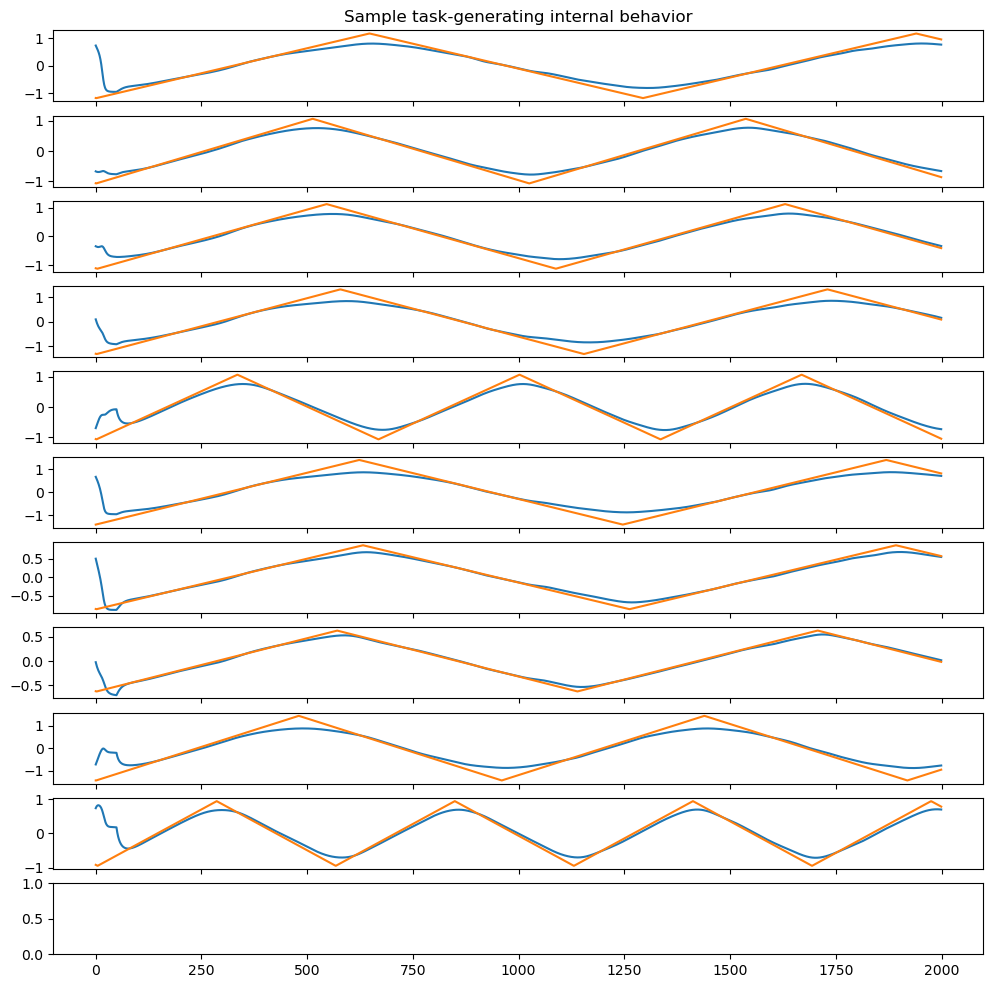

In [15]:
n_plot = 10
nloop = trpar['training_loops']
timesteps = int(tpar['total_time']/tpar['dt'])
btp = 99

fig, axs = plt.subplots(n_plot + 1, 1, figsize = (12, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Hx[i, (btp)*timesteps:(btp + 1)*timesteps])
    axs[i].plot(stargs[i])

axs[0].set_title("Sample task-generating internal behavior")

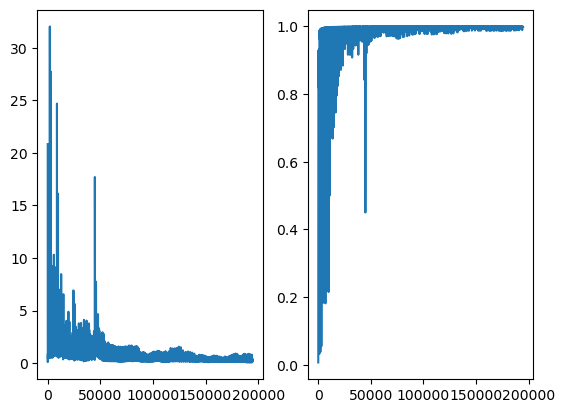

In [26]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(errs)
axs[1].plot(rel_errs)

In [27]:
xr, hxr = net.run_rate(stim)

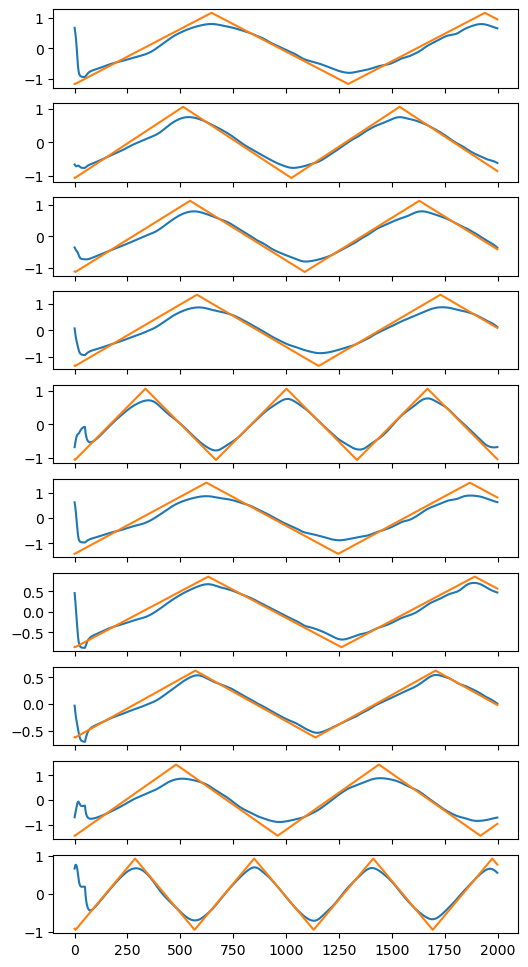

In [28]:
n_plot = 10
nloop = net.nloop
timesteps = int(net.run_time / net.dt)

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(hxr[i])
    axs[i].plot(stargs[i])
    #axs[i].plot(stim[i])

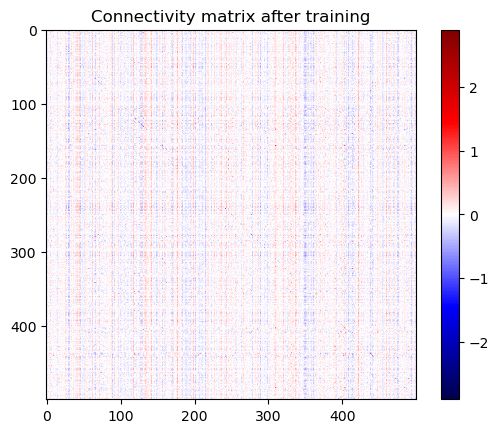

In [29]:
m = max(-1*np.min(net.W_trained), np.max(net.W_trained))

plt.imshow(net.W_trained, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)
plt.title("Connectivity matrix after training")
plt.colorbar()

c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


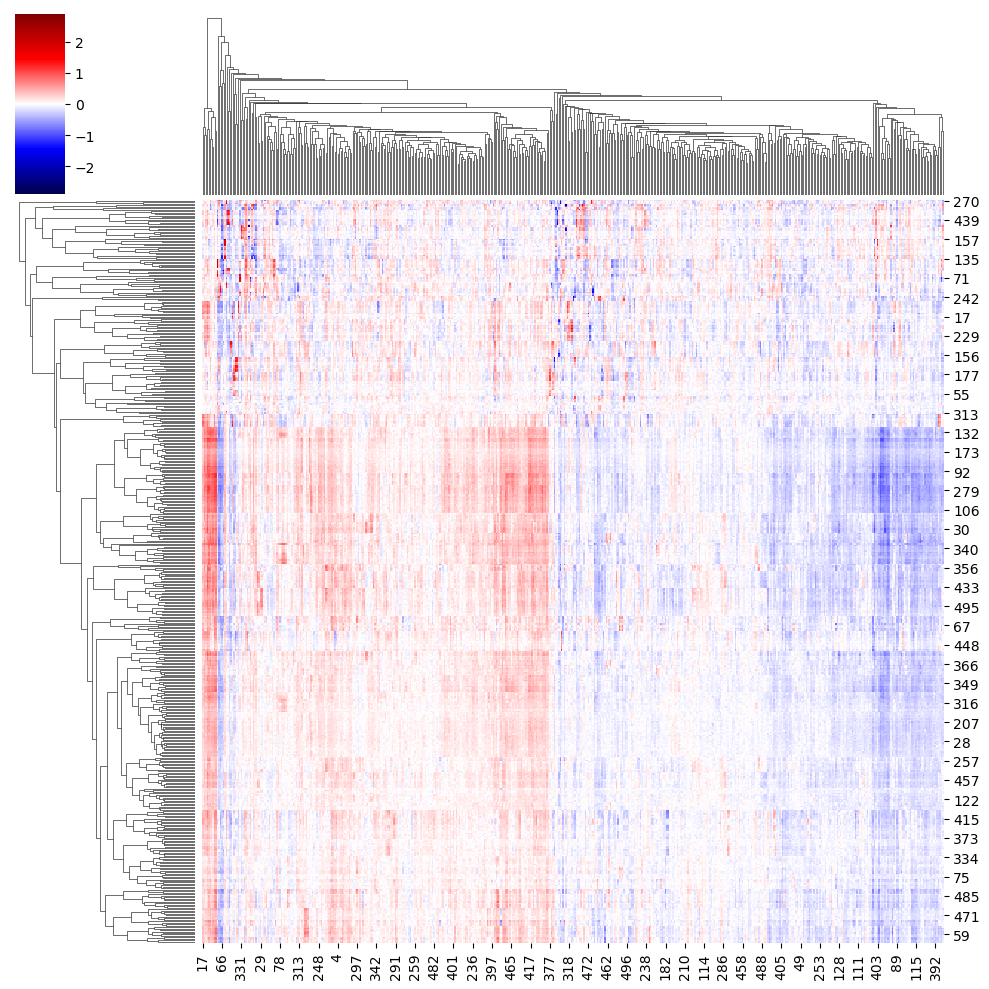

In [30]:
sns.clustermap(net.W_trained, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)

Text(0.5, 1.0, 'Magnitude of eigenvalues')

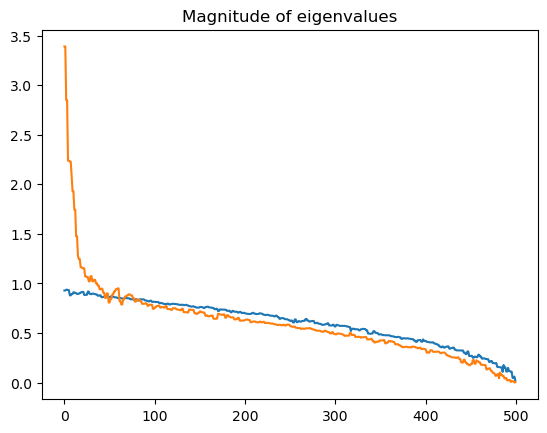

In [31]:
eigs_pre = np.linalg.eigvals(net.W_init)
eigs_post = np.linalg.eigvals(net.W_trained)

plt.plot(np.absolute(eigs_pre))
plt.plot(np.absolute(eigs_post))
plt.title("Magnitude of eigenvalues")

[-3.38796369+0.13952434j -3.38796369-0.13952434j]


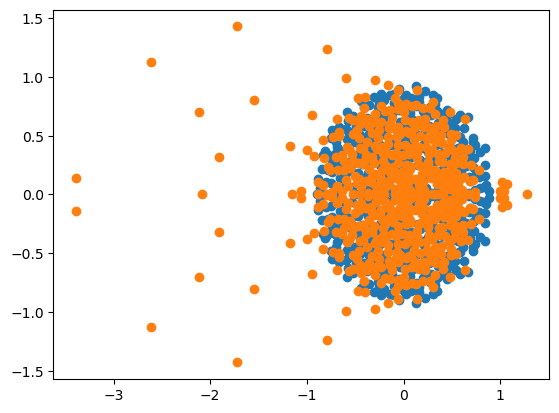

In [32]:
plt.scatter(np.real(eigs_pre), np.imag(eigs_pre))
plt.scatter(np.real(eigs_post), np.imag(eigs_post))
print(eigs_post[0:2])

In [23]:
P = np.array([[1, 0, 0],[0, 1, -1],[0, -1, 1]])
Hx = np.array([1, 3, 4])
aux_targ = np.array([3, 2, 1])
W = np.array([[0, 1, -1],[1, 2, -1],[0, 0, 1]])

In [24]:
for i in range(1):
    numer = np.outer(np.dot(P, Hx), np.dot(P, Hx))
    denom = 1 + np.dot(np.transpose(Hx), np.dot(P, Hx))
    P = P - numer / denom
    # k = np.transpose(np.dot(P, self.Hx)) / denom

    # update error
    err = np.dot(W, Hx) - aux_targ # error is vector
    #oerr = np.dot(self.W_out, self.Hx) - fout[itr] # error is scalar

    # update connectivity
    W = W - np.outer(err, np.dot(P, Hx))

# update output weights
#self.W_out = self.W_out - oerr * np.dot(P, self.Hx)

In [25]:
P

array([[ 0.66666667,  0.33333333, -0.33333333],
       [ 0.33333333,  0.66666667, -0.66666667],
       [-0.33333333, -0.66666667,  0.66666667]])

In [110]:
err

array([-4,  1,  3])

In [111]:
W

array([[ 1.33333333e+00, -3.33333333e-01,  3.33333333e-01],
       [ 6.66666667e-01,  2.33333333e+00, -1.33333333e+00],
       [-1.00000000e+00,  1.00000000e+00, -4.44089210e-16]])

In [112]:
denom

3

In [113]:
numer

array([[ 1, -1,  1],
       [-1,  1, -1],
       [ 1, -1,  1]])

In [114]:
Pff = np.array([[1, 0, 0],[0, 1, -1],[0, -1, 1]])
r = np.transpose(np.array([[1, 3, 4]]))
aux_targff = np.transpose(np.array([[3, 2, 1]]))
J = np.array([[0, 1, -1],[1, 2, -1],[0, 0, 1]])

In [115]:
jerr = np.dot(J, r) - aux_targff 
jerr

array([[-4],
       [ 1],
       [ 3]])

In [116]:
Pr = np.dot(Pff, r)
k = np.transpose(Pr) / (1 + np.dot(np.transpose(r), Pr))
Pff = Pff - np.dot(Pr, k)

In [117]:
Pff

array([[ 0.66666667,  0.33333333, -0.33333333],
       [ 0.33333333,  0.66666667, -0.66666667],
       [-0.33333333, -0.66666667,  0.66666667]])

In [118]:
J = J - np.dot(jerr, k)
J

array([[ 1.33333333, -0.33333333,  0.33333333],
       [ 0.66666667,  2.33333333, -1.33333333],
       [-1.        ,  1.        ,  0.        ]])

In [122]:
np.outer(err, np.dot(P, Hx))

array([[-1.33333333,  1.33333333, -1.33333333],
       [ 0.33333333, -0.33333333,  0.33333333],
       [ 1.        , -1.        ,  1.        ]])